In [1]:
#Libraries
import pandas as pd
import numpy as np
from collections import defaultdict
import seaborn as sns 
%matplotlib inline
import matplotlib.pyplot as plt
import functions
import datetime
from scipy.stats import chi2_contingency

In [2]:
# directory path for csv files (dataset from Jan to Jun 2018)
df_names=['data/yellow_tripdata_2018-01.csv','data/yellow_tripdata_2018-02.csv',
          'data/yellow_tripdata_2018-03.csv','data/yellow_tripdata_2018-04.csv',
         'data/yellow_tripdata_2018-05.csv','data/yellow_tripdata_2018-06.csv']

# taxi_zone_lookup.csv file
taxi_zone_lookup = pd.read_csv('data/taxi_zone_lookup.csv')

# names of the boroughs
borough_lst = list(np.unique(taxi_zone_lookup.Borough))
borough_lst.pop()

'Unknown'

# The number of payments for any possible means

In [3]:
df,payment_type_lst=functions.payments_per_borough(df_names,taxi_zone_lookup,borough_lst)

In [4]:
df

,Credit card,Cash,No charge,Dispute
Borough,,,,
Bronx,3758.0,3278.0,187.0,41.0
Brooklyn,55873.0,29393.0,1071.0,266.0
EWR,387.0,68.0,30.0,8.0
Manhattan,4191502.0,1809271.0,28365.0,8150.0
Queens,287906.0,126056.0,4585.0,1233.0
Staten Island,51.0,32.0,5.0,2.0
Unknown,70402.0,30905.0,1359.0,317.0


In [5]:
payment_type_all=list(map(int,df.sum().values))
for ind in range(len(payment_type_lst)-len(df.columns)):
        payment_type_all.append(0)

In [6]:
payment_type_all

[4609879, 1999003, 35602, 10017, 0, 0]

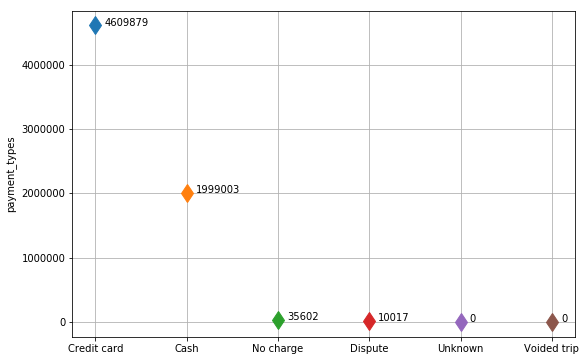

In [7]:
functions.payment_types_NYC_plot(payment_type_all,payment_type_lst)

# Chi-squared test

In [8]:
%%latex
\[H_0\text {={"The method of payment is NOT correlated to the borough"}}\]
\[H_1\text {={"The method of payment is correlated to the borough"}}\]

<IPython.core.display.Latex object>

In [9]:
df

,Credit card,Cash,No charge,Dispute
Borough,,,,
Bronx,3758.0,3278.0,187.0,41.0
Brooklyn,55873.0,29393.0,1071.0,266.0
EWR,387.0,68.0,30.0,8.0
Manhattan,4191502.0,1809271.0,28365.0,8150.0
Queens,287906.0,126056.0,4585.0,1233.0
Staten Island,51.0,32.0,5.0,2.0
Unknown,70402.0,30905.0,1359.0,317.0


In [10]:
chi2, p_value, dof, expected = chi2_contingency(df)

In [11]:
p_value

0.0

p_value is smaller than 0.01. Therefore, Null hypothesis can be rejected. 
And we can conclude that =>{"The method of payment is correlated to the borough"}. In other word there is a statistically significant correlation between method of payment and borough.

# The way payments are executed in each borough 

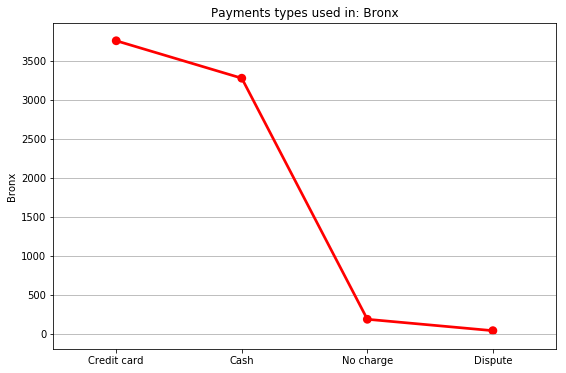

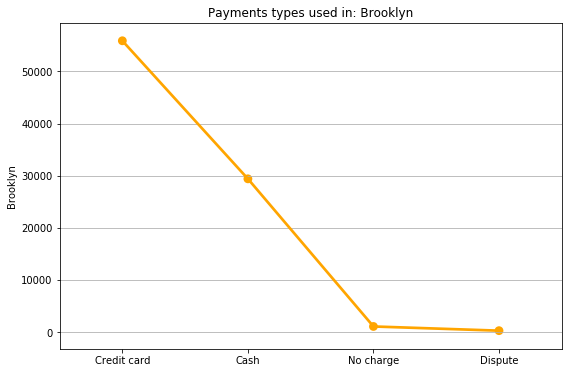

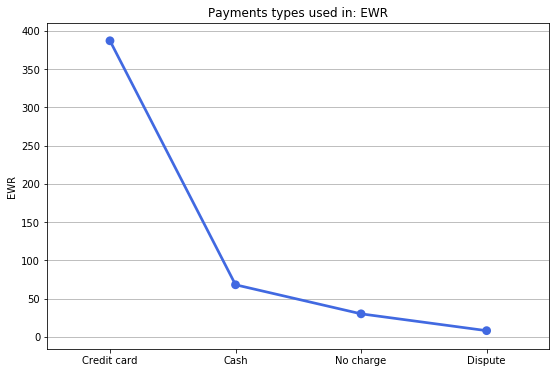

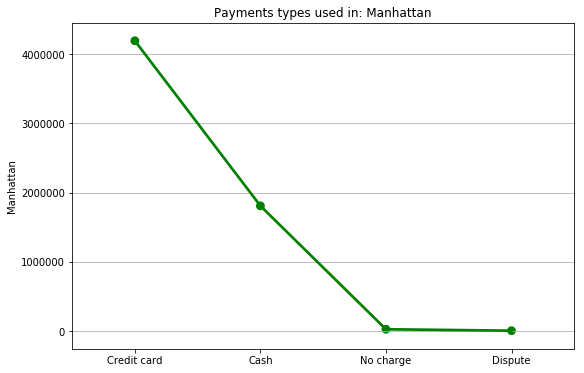

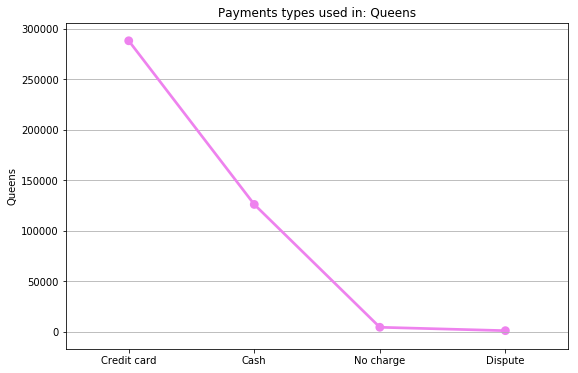

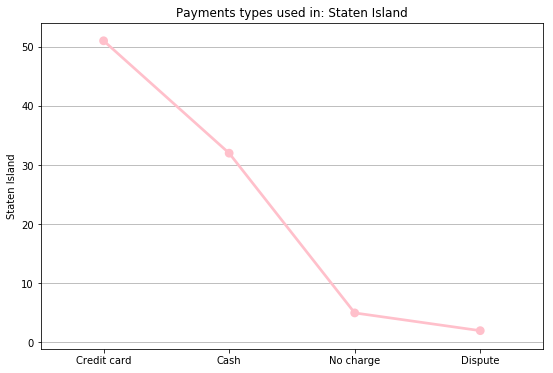

In [12]:
functions.payment_type_per_borough_plot(df,payment_type_lst)

When comparing methods of payments in each of the boroughs among each other based on the graphs it can be concluded:

That just like in the whole NYC, the most common mean of payment was the credit card, followed by cash.
The rides that ended with dispute were rare in all boroughs, as well as the ones that ended with no charge.